## Voting Methods 

This code contains the cross validation and final test of our voting method classifiers. The outline is as follows: 
* We import packages and preprocess our train data
* We instantiate the three models with optimized hyperparameters found by tuning with optuna
* We perform cross validation of all the models 
* We do a basic validation of our voting classifier on a train test split 
* We do the same with baseline models without optimized hyperparameters to compare performance
* We import and preprocess our two sets of test data, and then we test our final model

## Packages and Preprocessing

In [7]:
#### import packages ####

# os stuff
import sys
import os

#pandas and numpy
import pandas as pd
import numpy as np

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#sklearn packages
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.base import BaseEstimator, TransformerMixin

#import models
#XGBoost
import xgboost
from xgboost import XGBClassifier

#LightGBM
import lightgbm
from lightgbm import LGBMClassifier

#install and implement Catboost
import catboost
from catboost import CatBoostClassifier

In [8]:
# mount google drive - for use on google colab
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
# set paths for preprocessor
sys.path.append('/content/drive/MyDrive/Erdos/Project/summer-2025-hoax-detection/')

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from feature_engineer import (
    VandalismScorer,
    is_IP,
    account_age,
    comment_empty,
    word_count,
)

from feature_engineer import preprocessor

In [ ]:
#read the dataset
df = pd.read_csv("../Data/train.csv")
preprocessor(df)

# Models with optimized hyperparameters

In [11]:
## Make Base Models
# use the results of individual runs to get the optimal hyperparameters of each

xgb_params = {
    "max_depth": 9,
    "min_child_weight": 7,
    "gamma": 1.9024978934955494,
    "subsample": 0.7359660928342937,
    "colsample_bytree": 0.8765862797052864,
    "colsample_bylevel": 0.8791472442402003,
    "reg_alpha": 1.8456128259583087,
    "learning_rate": 0.056462992736512986,
    "n_estimators": 760
}

lgb_params = {'learning_rate': 0.019047994719728283, 
              'num_leaves': 128, 
              'n_estimators': 736, 
              'max_depth': 9,
              'verbosity':-1
}

cat_params = {'depth': 8,
               'l2_leaf_reg': 1.2247456637206777,
               'learning_rate': 0.012099911437243593, 
               'iterations': 901, 
               'subsample': 0.77188798045839, 
               'random_strength': 4.937806250714549, 
               'bagging_temperature': 0.6133034901535028, 
               'border_count': 157,
               'logging_level': 'Silent'
}

xgb = XGBClassifier(**xgb_params)

lgb = LGBMClassifier(**lgb_params)

cat = CatBoostClassifier(**cat_params)

In [12]:
voting = VotingClassifier([('xgb',xgb),
                           ('lgb',lgb),
                           ('cat',cat)],
                         voting='hard')

# Cross Validation

In [13]:
#cross validation

# feature selector class for use in the Vandalism Score pipeline
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.features]

#scoring metrics    
scoring = {
    'accuracy' : make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall'   : make_scorer(recall_score),
    'f1_score' : make_scorer(f1_score)
}

#features we want to run on
nfeatures = ['user_edit_count','user_distinct_pages',
             'user_warns','num_edits_5d_before', 
            'num_recent_edits','num_recent_reversions',
            'is_person','current_minor','account_age','comment_empty',
            'is_IP','word_count_added','word_count_deleted',
            'vandalism_score'
            ]

#unfit models
xgb_model = XGBClassifier(**xgb_params)

lgb_model = LGBMClassifier(**lgb_params)

cat_model = CatBoostClassifier(**cat_params)


# Pipelines
pipelines = {
    'XGBoost': Pipeline([
        ('scorer', VandalismScorer(n_splits=5, random_state=42)),
        ('select', FeatureSelector(nfeatures)),
        ('model', xgb_model)
    ]),
    'LightGBM': Pipeline([
        ('scorer', VandalismScorer(n_splits=5, random_state=42)),
        ('select', FeatureSelector(nfeatures)),
        ('model', lgb_model)
    ]),
    'CatBoost': Pipeline([
        ('scorer', VandalismScorer(n_splits=5, random_state=42)),
        ('select', FeatureSelector(nfeatures)),
        ('model', cat_model)
    ]),
    'VotingClassifier': Pipeline([
        ('scorer', VandalismScorer(n_splits=5, random_state=42)),
        ('select', FeatureSelector(nfeatures)),
        ('model', VotingClassifier([
            ('xgb', XGBClassifier(**xgb_params)),
            ('lgb', LGBMClassifier(**lgb_params)),
            ('cat', CatBoostClassifier(**cat_params))
        ], voting='hard'))
    ])
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate all
for name, pipeline in pipelines.items():
    print(f"\n{name} Scores:")
    results = cross_validate(
        pipeline, df.copy(), df['isvandalism'].copy(),
        cv=cv, scoring=scoring
    )
    for metric in scoring.keys():
        print(f"{metric}: {results[f'test_{metric}'].mean():.4f}")


XGBoost Scores:
accuracy: 0.9149
precision: 0.9271
recall: 0.8956
f1_score: 0.9111

LightGBM Scores:
accuracy: 0.9154
precision: 0.9272
recall: 0.8968
f1_score: 0.9117

CatBoost Scores:
accuracy: 0.9161
precision: 0.9265
recall: 0.8991
f1_score: 0.9126

VotingClassifier Scores:
accuracy: 0.9163
precision: 0.9283
recall: 0.8974
f1_score: 0.9126


# Model Fitting on training for validation

xgb_clf training set metrics
Accuracy : 0.9131
Precision: 0.9255
Recall   : 0.8934
F1 Score : 0.9092

Confusion Matrix:
[[2432  178]
 [ 264 2212]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9021    0.9318    0.9167      2610
        True     0.9255    0.8934    0.9092      2476

    accuracy                         0.9131      5086
   macro avg     0.9138    0.9126    0.9129      5086
weighted avg     0.9135    0.9131    0.9130      5086



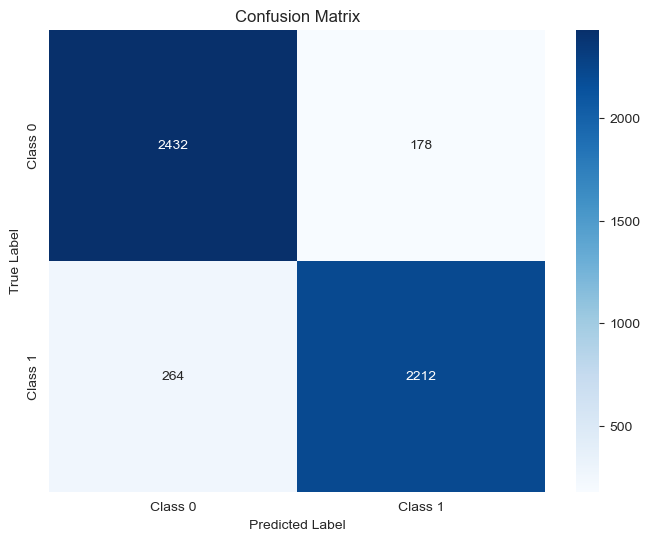

lgb_clf training set metrics
Accuracy : 0.9115
Precision: 0.9249
Recall   : 0.8905
F1 Score : 0.9074

Confusion Matrix:
[[2431  179]
 [ 271 2205]]

Classification Report:
              precision    recall  f1-score   support

       False     0.8997    0.9314    0.9153      2610
        True     0.9249    0.8905    0.9074      2476

    accuracy                         0.9115      5086
   macro avg     0.9123    0.9110    0.9113      5086
weighted avg     0.9120    0.9115    0.9115      5086



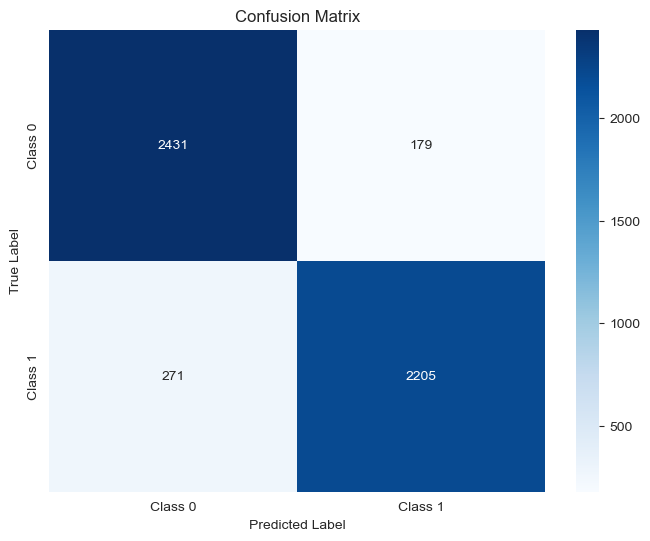

cat_clf training set metrics
Accuracy : 0.9143
Precision: 0.9232
Recall   : 0.8986
F1 Score : 0.9108

Confusion Matrix:
[[2425  185]
 [ 251 2225]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9062    0.9291    0.9175      2610
        True     0.9232    0.8986    0.9108      2476

    accuracy                         0.9143      5086
   macro avg     0.9147    0.9139    0.9141      5086
weighted avg     0.9145    0.9143    0.9142      5086



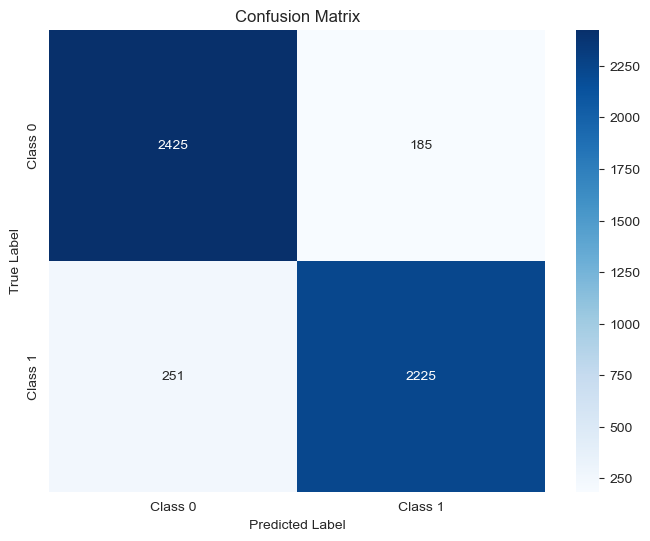

voting_clf training set metrics
Accuracy : 0.9141
Precision: 0.9260
Recall   : 0.8950
F1 Score : 0.9102

Confusion Matrix:
[[2433  177]
 [ 260 2216]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9035    0.9322    0.9176      2610
        True     0.9260    0.8950    0.9102      2476

    accuracy                         0.9141      5086
   macro avg     0.9147    0.9136    0.9139      5086
weighted avg     0.9144    0.9141    0.9140      5086



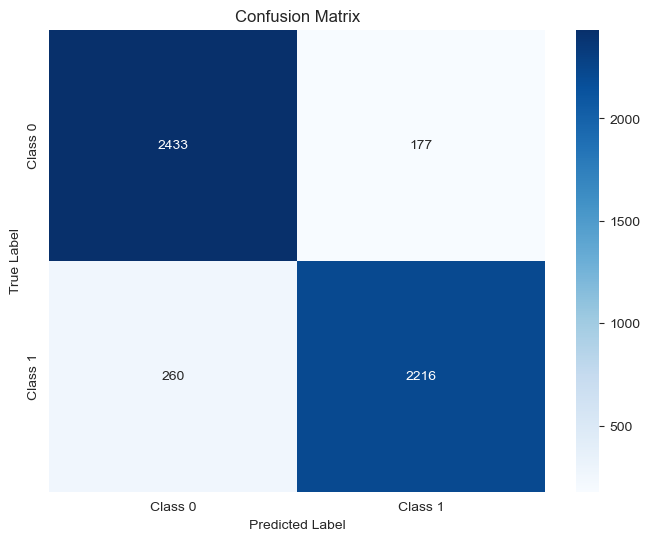


Best model: cat_clf with accuracy 0.91427


In [14]:
best_name = None
best_acc = 0

#train test split
df_tt, df_ho = train_test_split(df, test_size=0.2, random_state=42, stratify=df['isvandalism'],shuffle=True)

#scorer
scorer = VandalismScorer(n_splits=5, random_state=42)
df_tt = scorer.fit_transform(df_tt, df_tt['isvandalism'])
df_ho = scorer.transform(df_ho)

features = ['user_edit_count','user_distinct_pages',
             'user_warns','num_edits_5d_before', 
            'num_recent_edits','num_recent_reversions',
            'is_person','current_minor','account_age','comment_empty',
            'is_IP','word_count_added','word_count_deleted',
            'vandalism_score'
            ]

#fit each model and print their accuracy, then print the best accuracy score
for name,clf in (["xgb_clf",xgb],
                 ["lgb_clf",lgb],
                 ["cat_clf",cat],
                 ["voting_clf",voting]):
    # fit the model
    clf.fit(df_tt[features], df_tt.isvandalism)

    # predict
    y_pred = clf.predict(df_ho[features])

    # get acc
    accuracy = accuracy_score(df_ho.isvandalism, y_pred)
    precision = precision_score(df_ho.isvandalism, y_pred)
    recall = recall_score(df_ho.isvandalism, y_pred)
    f1 = f1_score(df_ho.isvandalism, y_pred)
    confmat = confusion_matrix(df_ho.isvandalism, y_pred)

    # Print metrics
    print(name,"training set metrics")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("\nConfusion Matrix:")
    print(confmat)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(df_ho.isvandalism, y_pred, digits=4))

    plt.figure(figsize=(8, 6)) # Adjust figure size as needed
    sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Class 0', 'Class 1'], # Replace with your actual class labels
                    yticklabels=['Class 0', 'Class 1']) # Replace with your actual class labels
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # update best
    if accuracy > best_acc:
        best_acc = accuracy
        best_name = name

print(f"\nBest model: {best_name} with accuracy {np.round(best_acc, 5)}")


Note: when running xbg and lgb with optimized hyperparameters and catboost with default parameters, we got


```
xgb_clf training set accuracy 0.92686
lgb_clf training set accuracy 0.92489
cat_clf training set accuracy 0.92587
voting_clf training set accuracy 0.92764

Best model: voting_clf with accuracy 0.92764
```



# Models with Default Parameters on training set

xgb_clf training set metrics
Accuracy : 0.9113
Precision: 0.9206
Recall   : 0.8950
F1 Score : 0.9076

Confusion Matrix:
[[2419  191]
 [ 260 2216]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9029    0.9268    0.9147      2610
        True     0.9206    0.8950    0.9076      2476

    accuracy                         0.9113      5086
   macro avg     0.9118    0.9109    0.9112      5086
weighted avg     0.9116    0.9113    0.9113      5086



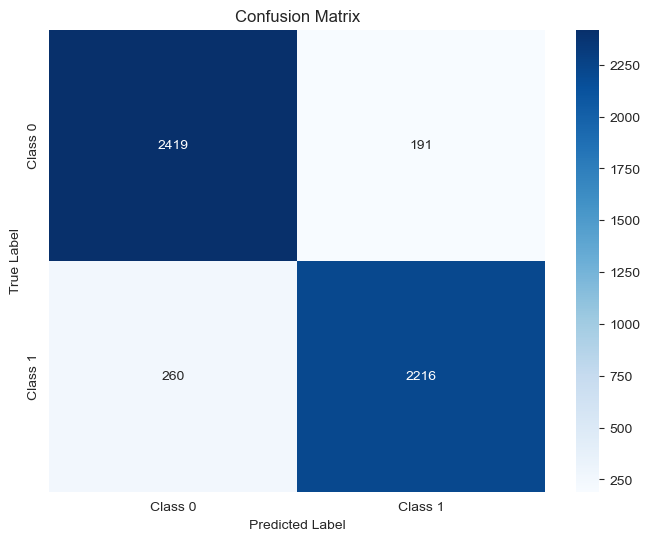

lgb_clf training set metrics
Accuracy : 0.9131
Precision: 0.9223
Recall   : 0.8970
F1 Score : 0.9095

Confusion Matrix:
[[2423  187]
 [ 255 2221]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9048    0.9284    0.9164      2610
        True     0.9223    0.8970    0.9095      2476

    accuracy                         0.9131      5086
   macro avg     0.9136    0.9127    0.9130      5086
weighted avg     0.9133    0.9131    0.9130      5086



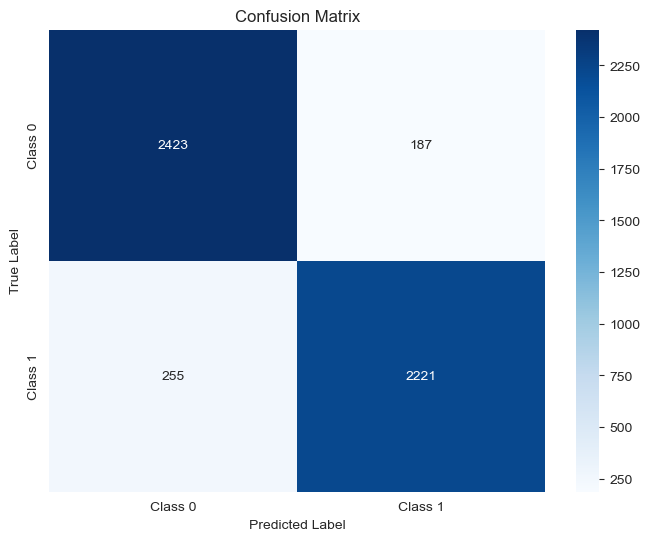

cat_clf training set metrics
Accuracy : 0.9155
Precision: 0.9277
Recall   : 0.8962
F1 Score : 0.9117

Confusion Matrix:
[[2437  173]
 [ 257 2219]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9046    0.9337    0.9189      2610
        True     0.9277    0.8962    0.9117      2476

    accuracy                         0.9155      5086
   macro avg     0.9161    0.9150    0.9153      5086
weighted avg     0.9158    0.9155    0.9154      5086



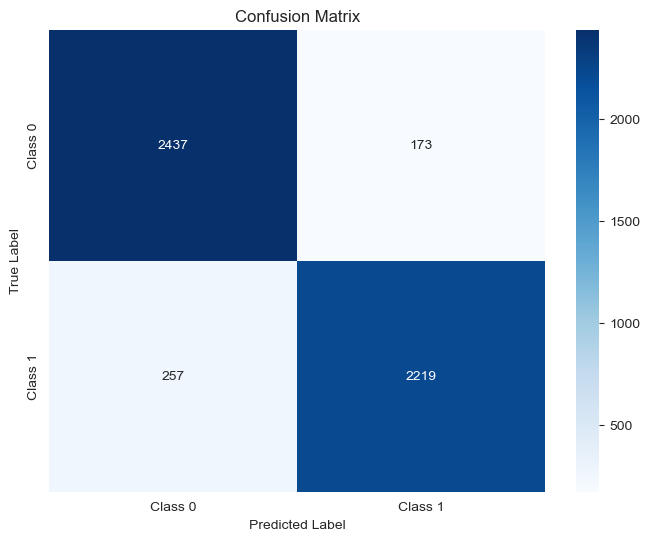

voting_clf training set metrics
Accuracy : 0.9135
Precision: 0.9238
Recall   : 0.8962
F1 Score : 0.9098

Confusion Matrix:
[[2427  183]
 [ 257 2219]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9042    0.9299    0.9169      2610
        True     0.9238    0.8962    0.9098      2476

    accuracy                         0.9135      5086
   macro avg     0.9140    0.9130    0.9133      5086
weighted avg     0.9138    0.9135    0.9134      5086



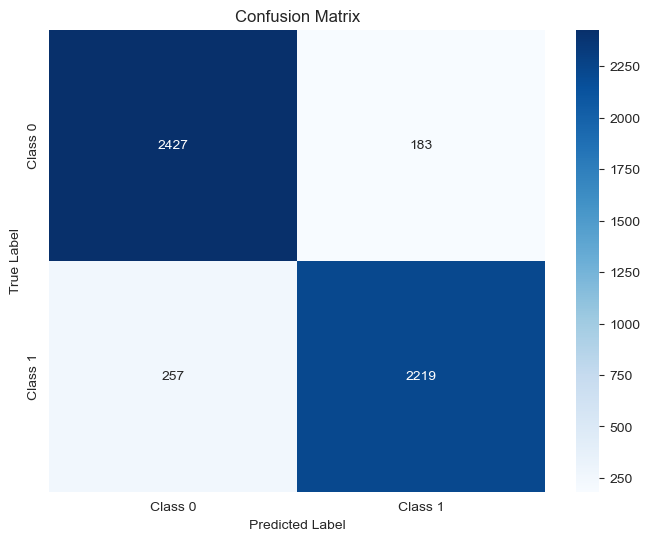


Best model: cat_clf with accuracy 0.91545


In [15]:
#Models with default parameters

xgb = XGBClassifier()

lgb = LGBMClassifier(verbosity=-1)

cat = CatBoostClassifier(logging_level='Silent')

voting = VotingClassifier([('xgb',xgb),
                           ('lgb',lgb),
                           ('cat',cat)],
                         voting='hard')

best_name = None
best_acc = 0
features = ['user_edit_count','user_distinct_pages',
             'user_warns','num_edits_5d_before', 
            'num_recent_edits','num_recent_reversions',
            'is_person','current_minor','account_age','comment_empty',
            'is_IP','word_count_added','word_count_deleted',
            'vandalism_score'
            ]


#fit each model and print their accuracy, then print the best accuracy score
for name,clf in (["xgb_clf",xgb],
                 ["lgb_clf",lgb],
                 ["cat_clf",cat],
                 ["voting_clf",voting]):
    # fit the model
    clf.fit(df_tt[features], df_tt.isvandalism)

    # predict
    y_pred = clf.predict(df_ho[features])

    # get acc
    accuracy = accuracy_score(df_ho.isvandalism, y_pred)
    precision = precision_score(df_ho.isvandalism, y_pred)
    recall = recall_score(df_ho.isvandalism, y_pred)
    f1 = f1_score(df_ho.isvandalism, y_pred)
    confmat = confusion_matrix(df_ho.isvandalism, y_pred)

    # Print metrics
    print(name,"training set metrics")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("\nConfusion Matrix:")
    print(confmat)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(df_ho.isvandalism, y_pred, digits=4))

    plt.figure(figsize=(8, 6)) # Adjust figure size as needed
    sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Class 0', 'Class 1'], # Replace with your actual class labels
                    yticklabels=['Class 0', 'Class 1']) # Replace with your actual class labels
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # update best
    if accuracy > best_acc:
        best_acc = accuracy
        best_name = name

print(f"\nBest model: {best_name} with accuracy {np.round(best_acc, 5)}")

## Threshold Testing

In [17]:
# Train/test split
X = df.copy()
y = df['isvandalism'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#pipelines
pipelines = {
    'XGBoost': Pipeline([
        ('scorer', VandalismScorer(n_splits=5, random_state=42)),
        ('select', FeatureSelector(nfeatures)),
        ('model', xgb_model)
    ]),
    'LightGBM': Pipeline([
        ('scorer', VandalismScorer(n_splits=5, random_state=42)),
        ('select', FeatureSelector(nfeatures)),
        ('model', lgb_model)
    ]),
    'CatBoost': Pipeline([
        ('scorer', VandalismScorer(n_splits=5, random_state=42)),
        ('select', FeatureSelector(nfeatures)),
        ('model', cat_model)
    ]),
    'VotingClassifier': Pipeline([
        ('scorer', VandalismScorer(n_splits=5, random_state=42)),
        ('select', FeatureSelector(nfeatures)),
        ('model', VotingClassifier([
            ('xgb', XGBClassifier(**xgb_params)),
            ('lgb', LGBMClassifier(**lgb_params)),
            ('cat', CatBoostClassifier(**cat_params))
        ], voting='hard'))
    ])
}


# Thresholds to evaluate
thresholds = np.linspace(0.0, 1.0, 200)

# For storing results
threshold_results = {}

for name, pipeline in pipelines.items():
    print(f"\nFitting {name}...")

    # Replace hard voting with soft for threshold testing
    if name == 'VotingClassifier':
        pipeline.set_params(model__voting='soft')

    # Fit model
    pipeline.fit(X_train, y_train)

    # Predict probabilities
    proba = pipeline.predict_proba(X_test)[:, 1]  # class 1 probability

    # Evaluate at different thresholds
    f1s, precisions, recalls,accuracies = [], [], [],[]
    for t in thresholds:
        pred = (proba >= t).astype(int)
        f1s.append(f1_score(y_test, pred))
        precisions.append(precision_score(y_test, pred, zero_division=0))
        recalls.append(recall_score(y_test, pred))
        accuracies.append(accuracy_score(y_test,pred))

    # Store results
    threshold_results[name] = {
        'thresholds': thresholds,
        'f1': f1s,
        'precision': precisions,
        'recall': recalls,
        'accuracy': accuracies,
        'best_threshold': thresholds[np.argmax(f1s)],
        'best_f1': max(f1s)
    }

    # Print best threshold
    print(f"Best threshold (F1): {threshold_results[name]['best_threshold']:.3f}")
    print(f"F1: {threshold_results[name]['best_f1']:.3f}")
    print(f"Precision: {precisions[np.argmax(f1s)]:.3f}")
    print(f"Recall: {recalls[np.argmax(f1s)]:.3f}")
    print(f"Accuracy: {accuracies[np.argmax(f1s)]:.3f}")


Fitting XGBoost...
Best threshold (F1): 0.347
F1: 0.911
Precision: 0.897
Recall: 0.926
Accuracy: 0.912

Fitting LightGBM...
Best threshold (F1): 0.402
F1: 0.914
Precision: 0.911
Recall: 0.917
Accuracy: 0.916

Fitting CatBoost...
Best threshold (F1): 0.412
F1: 0.914
Precision: 0.900
Recall: 0.927
Accuracy: 0.915

Fitting VotingClassifier...
Best threshold (F1): 0.462
F1: 0.914
Precision: 0.920
Recall: 0.907
Accuracy: 0.917


In [18]:
 # Print average threshold scores
for name, pipeline in pipelines.items():
  print(f"\nAverages for {name}")
  print(f"Average F1: {np.mean(f1s):.3f}")
  print(f"Average Precision: {np.mean(precisions):.3f}")
  print(f"Average Recall: {np.mean(recalls):.3f}")
  print(f"Average Accuracy: {np.mean(accuracies):.3f}")


Averages for XGBoost
Average F1: 0.877
Average Precision: 0.901
Average Recall: 0.871
Average Accuracy: 0.885

Averages for LightGBM
Average F1: 0.877
Average Precision: 0.901
Average Recall: 0.871
Average Accuracy: 0.885

Averages for CatBoost
Average F1: 0.877
Average Precision: 0.901
Average Recall: 0.871
Average Accuracy: 0.885

Averages for VotingClassifier
Average F1: 0.877
Average Precision: 0.901
Average Recall: 0.871
Average Accuracy: 0.885


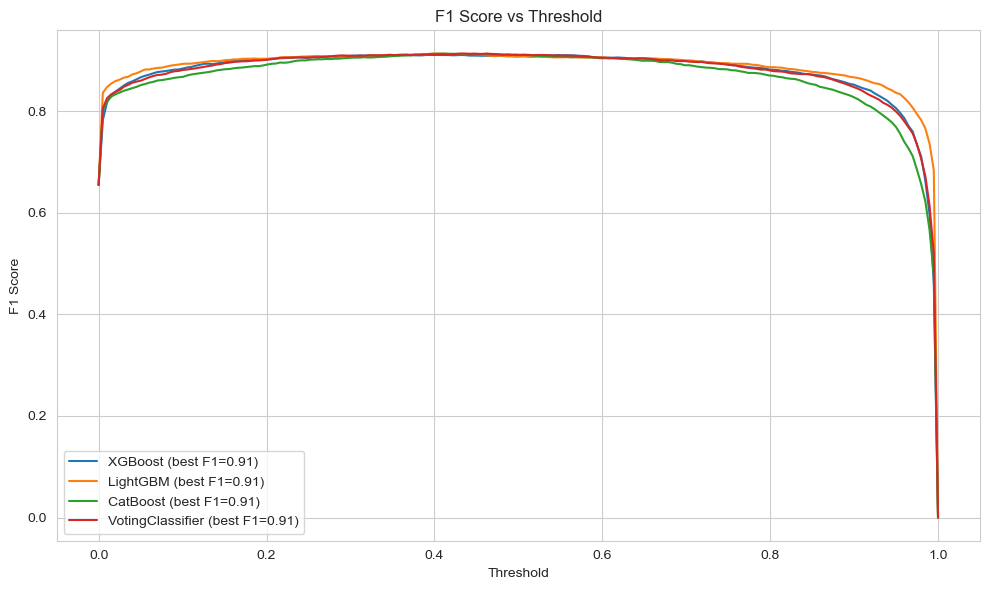

In [ ]:
# Plot F1 curves for all models
plt.figure(figsize=(10, 6))
for name, res in threshold_results.items():
    plt.plot(res['thresholds'], res['f1'], label=f'{name} (best F1={res["best_f1"]:.2f})')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("my_plot.png")
plt.show()


# Final Test

In [20]:
#train the model on the full data set
#model

features = ['user_edit_count','user_distinct_pages',
             'user_warns','num_edits_5d_before', 
            'num_recent_edits','num_recent_reversions',
            'is_person','current_minor','account_age','comment_empty',
            'is_IP','word_count_added','word_count_deleted',
            'vandalism_score'
            ]

full_model = Pipeline([
        ('scorer', VandalismScorer(n_splits=5, random_state=42)),
        ('select', FeatureSelector(features)),
        ('model', VotingClassifier([
            ('xgb', XGBClassifier(**xgb_params)),
            ('lgb', LGBMClassifier(**lgb_params)),
            ('cat', CatBoostClassifier(**cat_params))
        ], voting='hard'))])

full_model.fit(df,df.isvandalism)

Pipeline(steps=[('scorer', VandalismScorer(n_splits=5)),
                ('select',
                 FeatureSelector(features=['user_edit_count',
                                           'user_distinct_pages', 'user_warns',
                                           'num_edits_5d_before',
                                           'num_recent_edits',
                                           'num_recent_reversions', 'is_person',
                                           'current_minor', 'account_age',
                                           'comment_empty', 'is_IP',
                                           'word_count_added',
                                           'word_count_deleted',
                                           'vandalism_score'])),
                ('model',
                 Votin...
                                                             max_delta_step=None,
                                                             max_depth=9,
                                                             max_leaves=None,
                                                             min_child_weight=7,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=760,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...)),
                                              ('lgb',
                                               LGBMClassifier(learning_rate=0.019047994719728283,
                                                              max_depth=9,
                                                              n_estimators=736,
                                                              num_leaves=128,
                                                              verbosity=-1)),
                                              ('cat',
                                               <catboost.core.CatBoostClassifier object at 0x28e862720>)]))])

## Balanced Test set

In [21]:
#import and preprocess test data
test_df = pd.read_csv("../Data/test.csv")
preprocessor(test_df)

In [22]:
#make prediction
y_pred = full_model.predict(test_df)


Classification Report:
              precision    recall  f1-score   support

       False     0.9117    0.9414    0.9263      3259
        True     0.9361    0.9041    0.9198      3096

    accuracy                         0.9232      6355
   macro avg     0.9239    0.9227    0.9231      6355
weighted avg     0.9236    0.9232    0.9232      6355

0.9232100708103855
0.9198159710811699


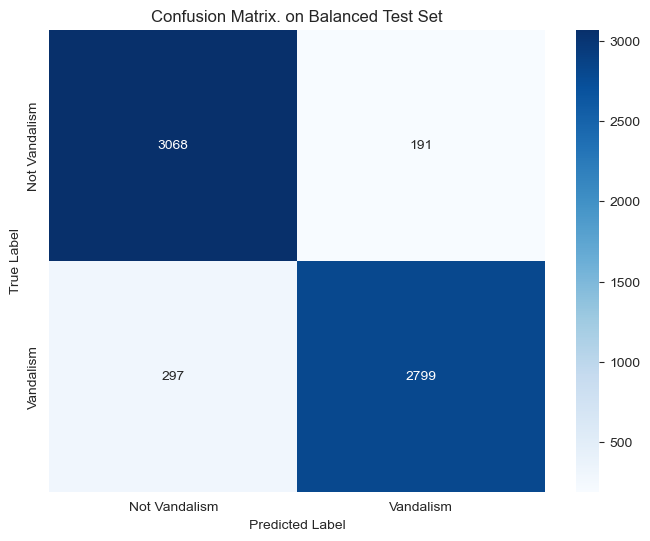

In [23]:
# Classification Report
print("\nClassification Report:")
print(classification_report(test_df.isvandalism, y_pred, digits=4))
print(accuracy_score(test_df.isvandalism, y_pred))
print(f1_score(test_df.isvandalism, y_pred))

#heatmap
confmat = confusion_matrix(test_df.isvandalism,y_pred)

plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Vandalism', 'Vandalism'],
                    yticklabels=['Not Vandalism', 'Vandalism'])
plt.title('Confusion Matrix. on Balanced Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#plt.savefig('Balanaced Confusion Matrix') #uncomment to save
plt.show()

## Imbalanced Test set

In [24]:
testimba_df =  pd.read_csv("../Data/test_imbalanced.csv")
preprocessor(testimba_df)

In [25]:
y_predimba = full_model.predict(testimba_df)

# Classification Report
print("\nClassification Report:")
print(classification_report(testimba_df.isvandalism, y_predimba, digits=4))
print(accuracy_score(testimba_df.isvandalism, y_predimba))
print(f1_score(testimba_df.isvandalism, y_predimba))



Classification Report:
              precision    recall  f1-score   support

       False     0.9613    0.6743    0.7926       479
        True     0.1832    0.7292    0.2929        48

    accuracy                         0.6793       527
   macro avg     0.5723    0.7017    0.5428       527
weighted avg     0.8904    0.6793    0.7471       527

0.6793168880455408
0.2928870292887029


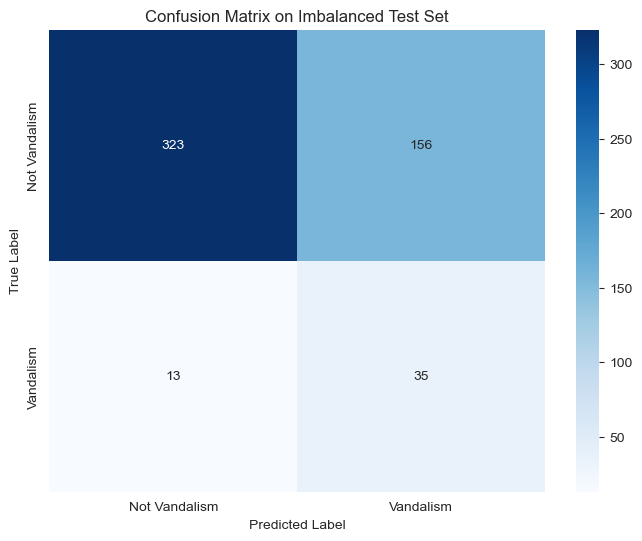

In [26]:
#heatmap
confmatimba = confusion_matrix(testimba_df.isvandalism, y_predimba)

plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(confmatimba, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Vandalism', 'Vandalism'],
                    yticklabels=['Not Vandalism', 'Vandalism'])
plt.title('Confusion Matrix on Imbalanced Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#plt.savefig('Imbalanaced Confusion Matrix') #uncomment to save
plt.show()